In [ ]:
!pip install transformers datasets evaluate sacrebleu bert_score accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import torch
import numpy as np
import evaluate
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import (
    BartTokenizerFast,
    BartForConditionalGeneration,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
)

import warnings
warnings.filterwarnings("ignore")

## Step 1: Dataset preparation and preprocessing

In [ ]:
dataset = load_dataset("multi_news")
print(dataset)

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

multi_news.py:   0%|          | 0.00/3.83k [00:00<?, ?B/s]

The repository for multi_news contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/multi_news.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


train.src.cleaned:   0%|          | 0.00/548M [00:00<?, ?B/s]

train.tgt:   0%|          | 0.00/58.8M [00:00<?, ?B/s]

val.src.cleaned:   0%|          | 0.00/66.9M [00:00<?, ?B/s]

val.tgt:   0%|          | 0.00/7.30M [00:00<?, ?B/s]

test.src.cleaned:   0%|          | 0.00/69.0M [00:00<?, ?B/s]

test.tgt:   0%|          | 0.00/7.31M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/44972 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5622 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5622 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['document', 'summary'],
        num_rows: 44972
    })
    validation: Dataset({
        features: ['document', 'summary'],
        num_rows: 5622
    })
    test: Dataset({
        features: ['document', 'summary'],
        num_rows: 5622
    })
})


In [ ]:
def datasetOverview(dataset):
    train_size = len(dataset["train"])
    val_size = len(dataset["validation"])
    test_size = len(dataset["test"])

    print(f"Training Samples:  {train_size}")
    print(f"Validation Samples: {val_size}")
    print(f"Test Samples:      {test_size}")

    print("Sample Entry from Training Set:")
    print(dataset["train"][0])

def analyzeTrainingLengths(dataset):
    train_docs = dataset["train"]["document"]
    train_summaries = dataset["train"]["summary"]

    doc_word_counts = [len(text.split()) for text in train_docs]
    summary_word_counts = [len(text.split()) for text in train_summaries]

    avg_doc_len = np.mean(doc_word_counts)
    avg_summary_len = np.mean(summary_word_counts)

    print("Average document length (train):", round(avg_doc_len, 2))
    print("Average summary length (train):", round(avg_summary_len, 2))


def analyzeValidationLengths(dataset):
    val_docs = dataset["validation"]["document"]
    val_summaries = dataset["validation"]["summary"]

    doc_word_counts = [len(text.split()) for text in val_docs]
    summary_word_counts = [len(text.split()) for text in val_summaries]

    avg_doc_len = np.mean(doc_word_counts)
    avg_summary_len = np.mean(summary_word_counts)

    print("Average document length (val):", round(avg_doc_len, 2))
    print("Average summary length (val):", round(avg_summary_len, 2))


print("dataset sizes and a sample: ")
datasetOverview(dataset)

print("\n Average lengths in training data: ")
analyzeTrainingLengths(dataset)

print("\n Average lengths in validation data: ")
analyzeValidationLengths(dataset)

dataset sizes and a sample: 
Training Samples:  44972
Validation Samples: 5622
Test Samples:      5622
Sample Entry from Training Set:
{'document': 'National Archives \n \n Yes, it’s that time again, folks. It’s the first Friday of the month, when for one ever-so-brief moment the interests of Wall Street, Washington and Main Street are all aligned on one thing: Jobs. \n \n A fresh update on the U.S. employment situation for January hits the wires at 8:30 a.m. New York time offering one of the most important snapshots on how the economy fared during the previous month. Expectations are for 203,000 new jobs to be created, according to economists polled by Dow Jones Newswires, compared to 227,000 jobs added in February. The unemployment rate is expected to hold steady at 8.3%. \n \n Here at MarketBeat HQ, we’ll be offering color commentary before and after the data crosses the wires. Feel free to weigh-in yourself, via the comments section. And while you’re here, why don’t you sign up to 

3. Preprocessing:

In [ ]:
# Loading tokenizer
baseModel = "facebook/bart-base"
bartTokenizer = BartTokenizerFast.from_pretrained(baseModel)

# maximum length for inputs and targets
sourceMaxLength = 1024
targetMaxLength = 256

def dataPreparationPreprosessing(batch):
    # Tokenize both inputs and targets
    # Articles are padded and truncated to 1024.
    # Summaries are padded and truncated to 256.

    sourceText = batch["document"]
    targetText = batch["summary"]

    tokenizedInput = bartTokenizer(
        sourceText,
        max_length=sourceMaxLength,
        truncation=True,
        padding="max_length"
    )

    with bartTokenizer.as_target_tokenizer():
        tokenizedTarget = bartTokenizer(
            targetText,
            max_length=targetMaxLength,
            truncation=True,
            padding="max_length"
        )["input_ids"]

    # Replacing padding tokens in target with -100
    updatedLabel = [
        [-100 if token == bartTokenizer.pad_token_id else token for token in seq]
        for seq in tokenizedTarget
    ]

    tokenizedInput["labels"] = updatedLabel
    return tokenizedInput

# Mapping the preprocessing function to each dataset split
tokenizedTrainData = dataset["train"].map(dataPreparationPreprosessing, batched=True, remove_columns=["document", "summary"])
tokenizedValData   = dataset["validation"].map(dataPreparationPreprosessing, batched=True, remove_columns=["document", "summary"])
tokenizedTestData  = dataset["test"].map(dataPreparationPreprosessing, batched=True, remove_columns=["document", "summary"])


tokenizedTrainData.save_to_disk("multi_news_tokenized_train")
tokenizedValData.save_to_disk("multi_news_tokenized_val")
tokenizedTestData.save_to_disk("multi_news_tokenized_test")


paddingColator = DataCollatorForSeq2Seq(tokenizer=bartTokenizer, model=baseModel)


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

Map:   0%|          | 0/44972 [00:00<?, ? examples/s]

Map:   0%|          | 0/5622 [00:00<?, ? examples/s]

Map:   0%|          | 0/5622 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/44972 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5622 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5622 [00:00<?, ? examples/s]

preprocessing methodology.


In the preprocessing step I  implemented tokenization of input document and their respective summaries using the BartTokenizerFast from the facebook/bart-base model using Hugging Face's map() function with batching enabled for efficiency. Each document was truncated and padded to a maximum of 1024 tokens with summaries truncated and padded to 256 tokens max. Truncating documents prevents long input text from breaking the model length limit, while padding documents ensures that all input in a given batch have the same input shape for appropriate batching. In the case of summarizing tokenization padding tokens were replaced by -100 to ensure these tokens were ignored for calculating the loss. I also wrapped this tokenizer with a DataCollatorForSeq2Seq to dynamically pad specific training data. Lastly I saved all pre-processed datasets locally so I do not have to reprocess the data.

## Step 2: Model Fine-Tuning

Useing the pre-trained model `facebook/bart-base` from Hugging Face.

In [ ]:
# Defining BART Model
model = BartForConditionalGeneration.from_pretrained(baseModel)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Using device:", device)

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Using device: cuda


In [ ]:
pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=40ee95202509850fd39d54113fcf46ae9111e098705dd380cf38f4dd1b2cee14
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
# Defining and loading metrics ROUGE, BLEU, BERTScore
metricRouge = evaluate.load("rouge")
metricBleu  = evaluate.load("sacrebleu")
metricBert  = evaluate.load("bertscore")

def decodeOutput(pred_ids, tokenizer):
    if isinstance(pred_ids, torch.Tensor):
        pred_ids = pred_ids.detach().cpu().numpy()
    pred_ids = np.clip(pred_ids.astype(np.int64), 0, tokenizer.vocab_size - 1)
    return tokenizer.batch_decode(pred_ids, skip_special_tokens=True)

def evaluateComputeMetrics(eval_predictions):
    generated, reference = eval_predictions

    # Decoding predicted sequences
    generatedText = decodeOutput(generated, bartTokenizer)

    # Decoding reference labels while ignoring special padding value -100
    referenceText = []
    for target in reference:
        filtered_ids = [token_id for token_id in target if token_id != -100]
        referenceText.append(bartTokenizer.decode(filtered_ids, skip_special_tokens=True))

    # Computing ROUGE score
    rougeResult = metricRouge.compute(predictions=generatedText, references=referenceText)
    scoreRouge1 = round(rougeResult["rouge1"] * 100, 2)
    scoreRouge2 = round(rougeResult["rouge2"] * 100, 2)
    scoreRougeL = round(rougeResult["rougeL"] * 100, 2)

    # Computing BLEU score
    bleuResult = metricBleu.compute(
        predictions=generatedText,
        references=[[ref] for ref in referenceText]
    )
    scoreBleu = round(bleuResult["score"], 2)

    # Computing BERTScore
    bertResult = metricBert.compute(
        predictions=generatedText,
        references=referenceText,
        lang="en"
    )
    scoreBert_f1 = round(float(np.mean(bertResult["f1"])) * 100, 2)

    return {
        "rouge1": scoreRouge1,
        "rouge2": scoreRouge2,
        "rougeL": scoreRougeL,
        "bleu": scoreBleu,
        "bert_f1": scoreBert_f1,
    }

2. Training:

   - Fine-tune the model on the tokenized training set.

In [ ]:
# Setting up training arguments
def configureTrainArgs(output_path="bart-multinews-checkpoints"):
    return Seq2SeqTrainingArguments(
        output_dir=output_path,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        logging_steps=500,
        learning_rate=3e-5,
        per_device_train_batch_size=1,
        per_device_eval_batch_size=1,
        gradient_accumulation_steps=4,
        num_train_epochs=5,
        warmup_steps=500,
        weight_decay=0.01,
        fp16=torch.cuda.is_available(),
        predict_with_generate=True,
        generation_max_length=256,
        push_to_hub=False
    )

# Initializing custom Trainer
def setupTrainer(model, tokenizer, train_data, val_data, data_collator, compute_metrics_fn, args):
    trainerInstance = Seq2SeqTrainer(
        model=model,
        args=args,
        train_dataset=train_data,
        eval_dataset=val_data,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics_fn
    )
    return trainerInstance


# Creating training args
args = configureTrainArgs()

# Creating a smaller subset of train data and val data and used 1000 samples from the training set and 100 from the validation set.
subsetTrain = tokenizedTrainData.select(range(1000))
subsetVal = tokenizedValData.select(range(100))

# Initializing the trainer
trainer = setupTrainer(
    model=model,
    tokenizer=bartTokenizer,
    train_data=subsetTrain,
    val_data=subsetVal,
    data_collator=paddingColator,
    compute_metrics_fn=evaluateComputeMetrics,
    args=args
)

   - Monitor training and validation loss over epochs.

In [ ]:
# Training
trainOutput = trainer.train()

trainer.save_model()
trainer.log_metrics("train", trainOutput.metrics)
trainer.save_metrics("train", trainOutput.metrics)

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Bleu,Bert F1
1,3.232900,2.680757,36.970000,11.540000,19.480000,8.310000,85.410000
2,2.890900,2.679087,37.570000,12.870000,20.200000,8.520000,85.730000
3,2.688900,2.630986,37.930000,12.690000,20.130000,8.950000,85.640000
4,2.502900,2.625928,40.090000,13.750000,21.190000,11.320000,85.730000
5,2.384100,2.627940,40.370000,13.840000,20.750000,11.460000,85.710000


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


***** train metrics *****
  epoch                    =        5.0
  total_flos               =  2850096GF
  train_loss               =     2.7399
  train_runtime            = 0:31:33.11
  train_samples_per_second =      2.641
  train_steps_per_second   =       0.66


training methodology (e.g., hyperparameters used, training process, and any challenges faced).


To train the model I fine-tuned the facebook/bart-base model using 1000 training sample and 100 validation sample from the Multi-News dataset. A learning rate of 3e-5 was used with batch size 1 with 4 step of gradient accumulation and giving an effective batch size of 4. The model was trained for 5 epoch. The model used mixed precision (i.e. fp16) to speed up and reduce memory usage during training. The Seq2SeqTrainer was used with the evaluation_strategy="epoch" option to examine validation performance after each epoch and predict_with_generate=True to evaluate using the model generated summaries. The training loss and evaluation metrics were logged and visualized over each epoch to track performance throughout training.


One of the main challenges was managing GPU memory limits, which I addressed by reducing batch size and using gradient accumulation.

## Step 3: Evaluation and analysis

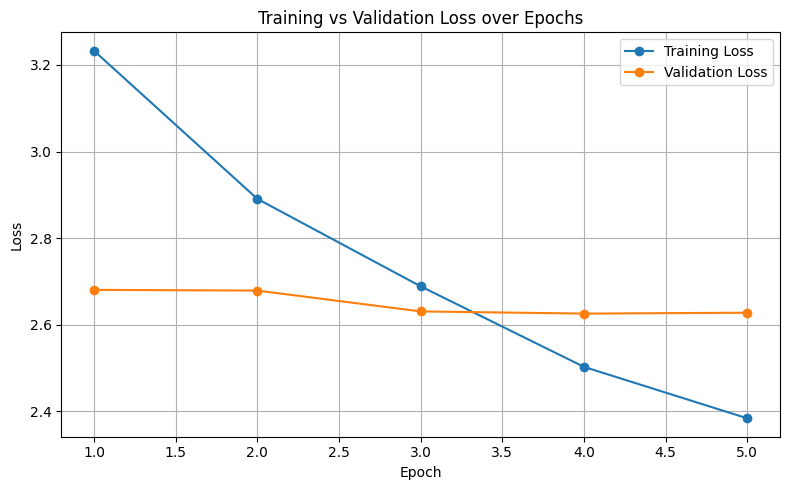

In [ ]:
# Plotting training and validation Loss over epochs
def plotTrainerLossCurves(trainer):
    training_epochs, training_loss_vals = [], []
    validation_epochs, validation_loss_vals = [], []

    for record in trainer.state.log_history:
        if record.get("loss") is not None and record.get("epoch") is not None:
            training_loss_vals.append(record["loss"])
            training_epochs.append(record["epoch"])
        if record.get("eval_loss") is not None and record.get("epoch") is not None:
            validation_loss_vals.append(record["eval_loss"])
            validation_epochs.append(record["epoch"])

    plt.figure(figsize=(8, 5))
    plt.plot(training_epochs, training_loss_vals, label="Training Loss", marker='o')
    plt.plot(validation_epochs, validation_loss_vals, label="Validation Loss", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plotTrainerLossCurves(trainer)

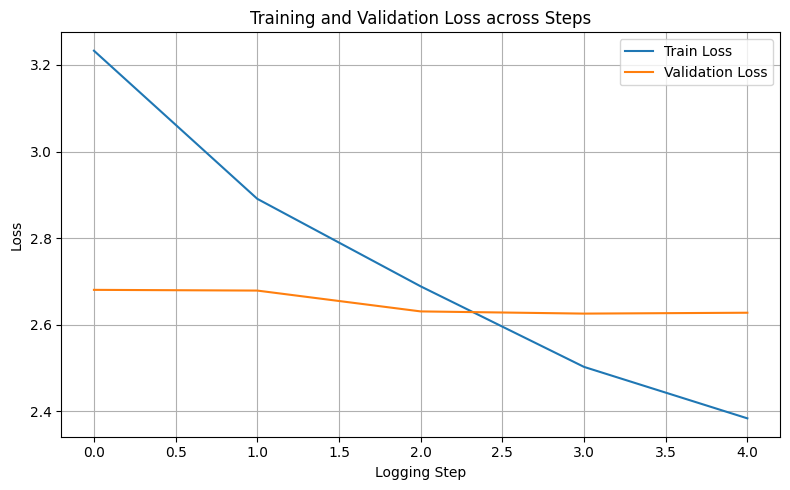

In [ ]:
# Plotting training and validation Loss over logging steps
def stepwiseLossProgress(trainer):
    recorded_train_losses = []
    recorded_val_losses = []

    for entry in trainer.state.log_history:
        if "loss" in entry:
            recorded_train_losses.append(entry["loss"])
        if "eval_loss" in entry:
            recorded_val_losses.append(entry["eval_loss"])

    plt.figure(figsize=(8, 5))
    plt.plot(recorded_train_losses, label="Train Loss")
    plt.plot(recorded_val_losses, label="Validation Loss")
    plt.xlabel("Logging Step")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss across Steps")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

stepwiseLossProgress(trainer)

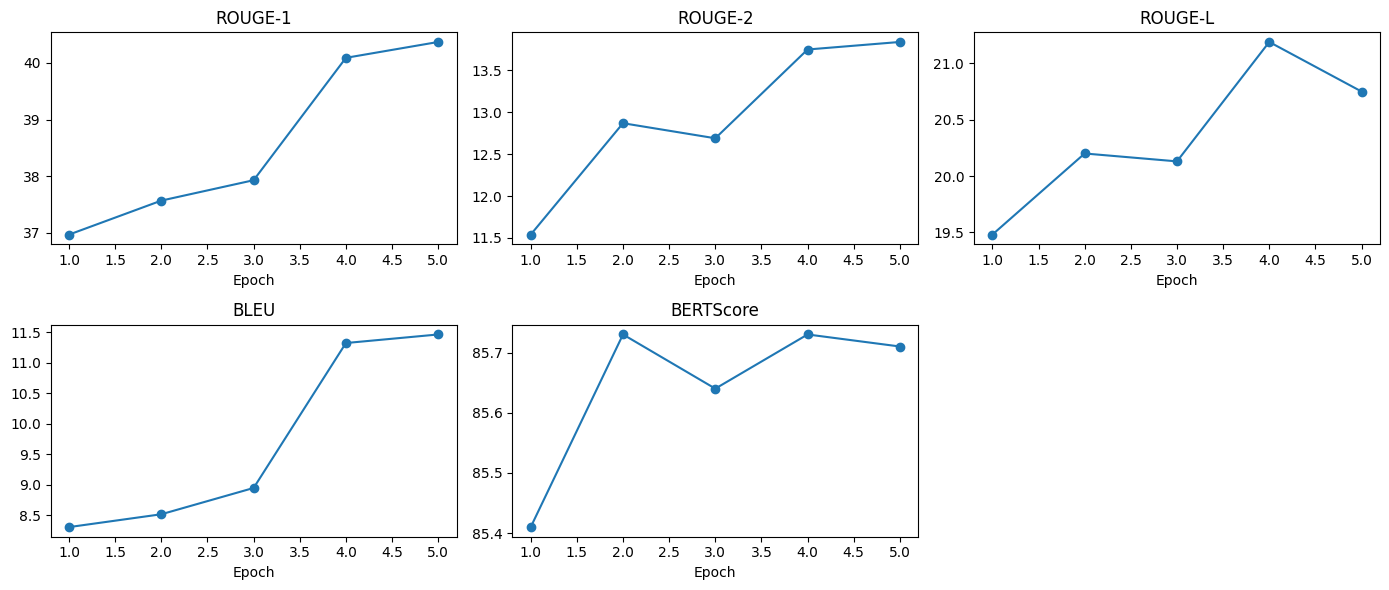

In [ ]:
# Plotting separate metrics ROUGE, BLEU, BERT over epochs
def plotEvaluationMetrics(trainer):
    epochs, rouge_1, rouge_2, rouge_L = [], [], [], []
    bleu_scores, bert_f1_scores = [], []

    for entry in trainer.state.log_history:
        if "eval_rouge1" in entry:
            epochs.append(entry["epoch"])
            rouge_1.append(entry["eval_rouge1"])
            rouge_2.append(entry["eval_rouge2"])
            rouge_L.append(entry["eval_rougeL"])
            bleu_scores.append(entry["eval_bleu"])
            bert_f1_scores.append(entry["eval_bert_f1"])

    plt.figure(figsize=(14, 6))

    metric_titles = ["ROUGE-1", "ROUGE-2", "ROUGE-L", "BLEU", "BERTScore"]
    metric_data = [rouge_1, rouge_2, rouge_L, bleu_scores, bert_f1_scores]

    for idx, (title, values) in enumerate(zip(metric_titles, metric_data), start=1):
        plt.subplot(2, 3, idx)
        plt.plot(epochs, values, marker='o')
        plt.title(title)
        plt.xlabel("Epoch")

    plt.tight_layout()
    plt.show()

plotEvaluationMetrics(trainer)

In [ ]:
# Evaluating on test data
def evaluateOnTestSet(trainer, tokenized_data, sample_size=500):
    subset = tokenized_data.select(range(sample_size))
    results = trainer.evaluate(eval_dataset=subset)
    print("Evaluation Results on Test Set:", results)
    trainer.log_metrics("test", results)
    trainer.save_metrics("test", results)
    return results

TestMetricesResult = evaluateOnTestSet(trainer, tokenizedTestData)

Evaluation Results on Test Set: {'eval_loss': 2.535705327987671, 'eval_rouge1': 41.87, 'eval_rouge2': 14.72, 'eval_rougeL': 21.65, 'eval_bleu': 11.81, 'eval_bert_f1': 86.16, 'eval_runtime': 1569.8678, 'eval_samples_per_second': 0.318, 'eval_steps_per_second': 0.318, 'epoch': 5.0}
***** test metrics *****
  epoch                   =        5.0
  eval_bert_f1            =      86.16
  eval_bleu               =      11.81
  eval_loss               =     2.5357
  eval_rouge1             =      41.87
  eval_rouge2             =      14.72
  eval_rougeL             =      21.65
  eval_runtime            = 0:26:09.86
  eval_samples_per_second =      0.318
  eval_steps_per_second   =      0.318


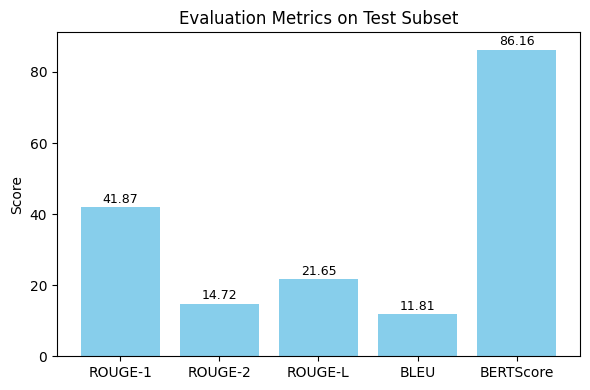

In [ ]:
# Bar chart of final test metrics
def testMetricBarPlot(test_metrics):
    metric_labels = ["ROUGE-1", "ROUGE-2", "ROUGE-L", "BLEU", "BERTScore"]
    metric_keys = ["eval_rouge1", "eval_rouge2", "eval_rougeL", "eval_bleu", "eval_bert_f1"]
    scores = [test_metrics[key] for key in metric_keys]

    plt.figure(figsize=(6, 4))
    bars = plt.bar(metric_labels, scores, color="skyblue")

    for bar, value in zip(bars, scores):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f"{value:.2f}",
                 ha='center', va='bottom', fontsize=9)

    plt.ylabel("Score")
    plt.title("Evaluation Metrics on Test Subset")
    plt.ylim(0, max(scores) + 5)
    plt.tight_layout()
    plt.show()

testMetricBarPlot(TestMetricesResult)

detailed analysis of the model’s performance for each evaluation metric.

The model performed well on all the evaluation metrics. The ROUGE-1 score of 41.87 and ROUGE-2 scores of 14.72 tells that the summaries have included many important words and phrase from the original article. The ROUGE-L score
 of 21.65 indicate that the model maintain the structure and order of content reasonably well. The BLEU score of 11.81 shows that the generated summary exhibit a congruency with the reference summaries in terms of word pattern and grammar. The BERTScore 86.16 was high which means that the summaries included similar meaning to the main article even with different words. Therefore the score confidently establish that the model is generating summaries that include meaning and are very accurate.

challenges faced during evaluation (e.g., handling long documents, variability in summary quality, etc.).


One of the significant during evaluation was working with long input document as a number of article in the Multi-News dataset exceeded the 1024 token BART model limit.  we had to truncate the input, which may lead to the omission of critical context and the potential for reduced summary quality. Additionally variability in human written summaries, in terms of both style and length, meant that the model didn't always neatly correlate with reference summaries. Finally computing evaluation metrics like BERTScore was tedious because this involved contextual embeddings. Limited GPU memory also imposed limits on how many test samples we could evaluate at once that is why the evaluations were subsequently conducted on smaller chunks.

Propose potential modifications or extensions to enhance summarization quality.


To improve summarization quality, we can use a larger model like facebook/bart-large for better understanding of longer texts. We can also try models made for long documents, like Longformer or LED. Increasing the input length limit beyond 1024 tokens can help include more context. Using more training data or fine-tuning for more epochs may also improve performance. Adding techniques like coverage loss or reinforcement learning could reduce repetition and improve summary quality. Finally, post-processing summaries to clean or shorten them can make the outputs more readable.

References.


1. https://huggingface.co/docs/transformers/index
2. https://huggingface.co/facebook/bart-base
3. https://huggingface.co/datasets/multi_news
4. https://huggingface.co/docs/evaluate
5. https://github.com/huggingface/transformers/blob/main/examples/pytorch/seq2seq/README.md
6. https://huggingface.co/blog
7. https://matplotlib.org/stable/index.html